Preamble to enable plotting
===

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import numpy as np

First Plot
========

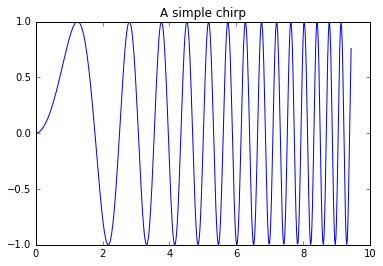

In [6]:
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp');

In [10]:
x

array([ 0.        ,  0.01888733,  0.03777466,  0.05666199,  0.07554932,
        0.09443665,  0.11332398,  0.13221131,  0.15109864,  0.16998598,
        0.18887331,  0.20776064,  0.22664797,  0.2455353 ,  0.26442263,
        0.28330996,  0.30219729,  0.32108462,  0.33997195,  0.35885928,
        0.37774661,  0.39663394,  0.41552127,  0.4344086 ,  0.45329593,
        0.47218326,  0.4910706 ,  0.50995793,  0.52884526,  0.54773259,
        0.56661992,  0.58550725,  0.60439458,  0.62328191,  0.64216924,
        0.66105657,  0.6799439 ,  0.69883123,  0.71771856,  0.73660589,
        0.75549322,  0.77438055,  0.79326788,  0.81215522,  0.83104255,
        0.84992988,  0.86881721,  0.88770454,  0.90659187,  0.9254792 ,
        0.94436653,  0.96325386,  0.98214119,  1.00102852,  1.01991585,
        1.03880318,  1.05769051,  1.07657784,  1.09546517,  1.1143525 ,
        1.13323983,  1.15212717,  1.1710145 ,  1.18990183,  1.20878916,
        1.22767649,  1.24656382,  1.26545115,  1.28433848,  1.30